# How does AusEFlux represent the Big Dry and subsequent triple La Nina?



In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx

import matplotlib.pyplot as plt

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
# from odc.geo.xr import rasterize

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [2]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from dask_utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [48]:
er_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ER_2003_2022_5km_quantiles_v1.1.nc'
gpp_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc'
nee_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_NEE_2003_2022_5km_quantiles_v1.1.nc'
et_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ET_2003_2022_5km_quantiles_v1.1.nc'
# ndvi_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2022.nc'

chunks=None#dict(latitude=250, longitude=250, time=1)

t_range='2003', '2022'

#SE AUS
lat_bounds = slice(355, 590)
lon_bounds = slice(575,840)

#All of Aus
# lat_bounds = slice(0, 680)
# lon_bounds = slice(0,840)

## Open data

And clip to lat/lon bounds

In [4]:
er = assign_crs(xr.open_dataset(er_path, chunks=chunks)['ER_median'].isel(latitude=lat_bounds, longitude=lon_bounds), crs='EPSG:4326')
gpp = assign_crs(xr.open_dataset(gpp_path, chunks=chunks)['GPP_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
nee = assign_crs(xr.open_dataset(nee_path, chunks=chunks)['NEE_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
et = assign_crs(xr.open_dataset(et_path, chunks=chunks)['ET_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')

er =  round_coords(er)
gpp =  round_coords(gpp)
nee =  round_coords(nee)
et =  round_coords(et)

### open burned area

In [79]:
burn = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbance_1km_monthly_2002_2021.nc').sel(time=slice('2019','2020')), crs='EPSG:4326')

In [80]:
burn = burn.odc.reproject(et.odc.geobox, resampling='average')
burn =  round_coords(burn)
burn = burn.sel(time=slice('2019-09', '2020-03'))
burn = burn.where(burn<10).sum('time')
burn = burn>0

In [ ]:
# ndvi = assign_crs(xr.open_dataset(ndvi_path, chunks=chunks)['kNDVI'], crs='EPSG:4326')
# ndvi = ndvi.odc.reproject(et.odc.geobox, resampling='average')
# ndvi = ndvi.isel(latitude=lat_bounds, longitude=lon_bounds)
# ndvi =  round_coords(ndvi)

## Plot timeseries

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=(11,4))
# gpp.mean(['latitude','longitude']).compute().plot(ax=ax, label='GPP')
# er.mean(['latitude','longitude']).compute().plot(ax=ax, label='ER')
# # nee.mean(['latitude','longitude']).plot(ax=ax, label='NEE')
# et.mean(['latitude','longitude']).compute().plot(ax=ax, label='ET')

# ax.legend(loc='best', fontsize=14)
# ax.set_ylabel('', fontsize=14)
# ax.set_title('SE Aus carbon and water fluxes');

## Calculate Anomalies

In [5]:
er_clim_mean = er.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
gpp_clim_mean = gpp.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
nee_clim_mean = nee.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()
et_clim_mean = et.sel(time=slice('2002', '2018')).groupby('time.month').mean().compute()

In [6]:
er_clim_std = er.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
gpp_clim_std = gpp.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
nee_clim_std = nee.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()
et_clim_std = et.sel(time=slice('2002', '2018')).groupby('time.month').std().compute()

In [7]:
er_anom = (er.groupby('time.month') - er_clim_mean).compute()
gpp_anom = (gpp.groupby('time.month') - gpp_clim_mean).compute()
nee_anom = (nee.groupby('time.month') - nee_clim_mean).compute()
et_anom = (et.groupby('time.month') - et_clim_mean).compute()

In [8]:
#standardized anom
def stand_anomalies(ds, clim_mean, clim_std):
    std_anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
    ds.groupby("time.month"),
    clim_mean, clim_std)
    return std_anom

er_std_anom = stand_anomalies(er, er_clim_mean, er_clim_std)
gpp_std_anom = stand_anomalies(gpp, gpp_clim_mean, gpp_clim_std)
nee_std_anom = stand_anomalies(nee, nee_clim_mean, nee_clim_std)
et_std_anom = stand_anomalies(et, et_clim_mean, et_clim_std)

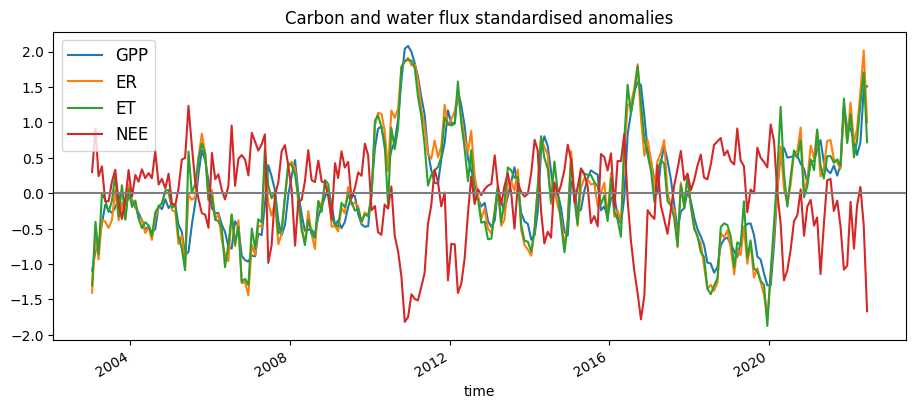

In [9]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='GPP')
er_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='ER')
et_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='ET')
nee_std_anom.mean(['latitude','longitude']).plot(ax=ax, label='NEE')

ax.legend(loc='best', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Carbon and water flux standardised anomalies');

## Maps of bushfires in 19-20

In [10]:
xx = [gpp_clim_mean, er_clim_mean, et_clim_mean, nee_clim_mean, ]
names = ['GPP', 'ER', 'ET', 'NEE']
# , gpp_anom, er_anom, nee_anom, et_anom

Text(0.5, 0.98, 'Flux Climatologies 2002-2018 ')

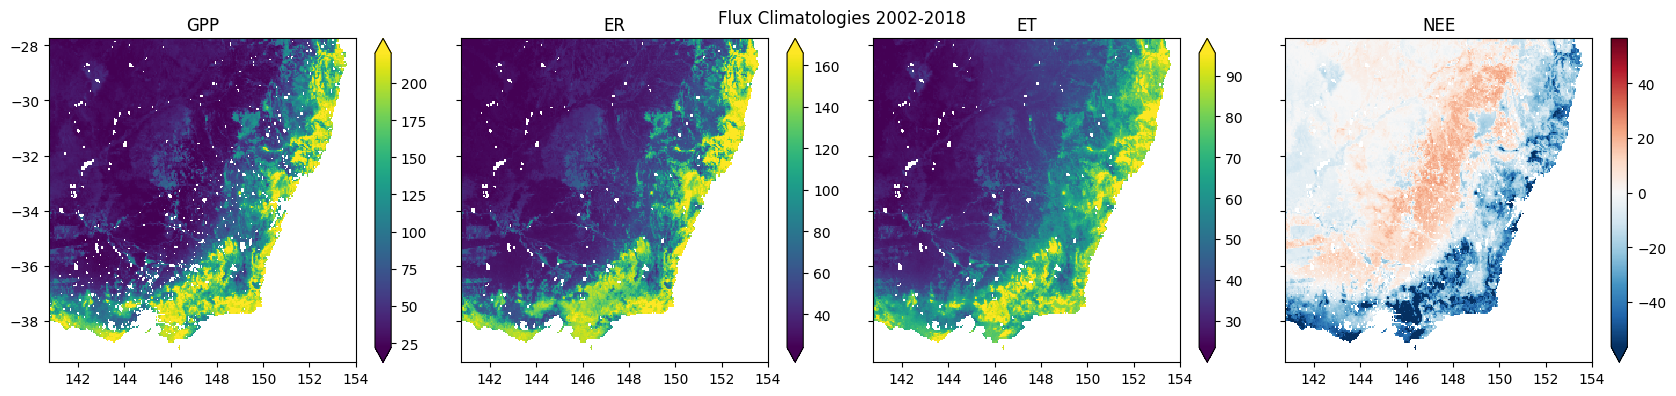

In [11]:
fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n in zip(ax.reshape(-1), xx, names): 
    x.sel(month=[10,11,12,1]).mean('month').rename('').plot.imshow(robust=True, ax=a, )
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Climatologies 2002-2018 ');

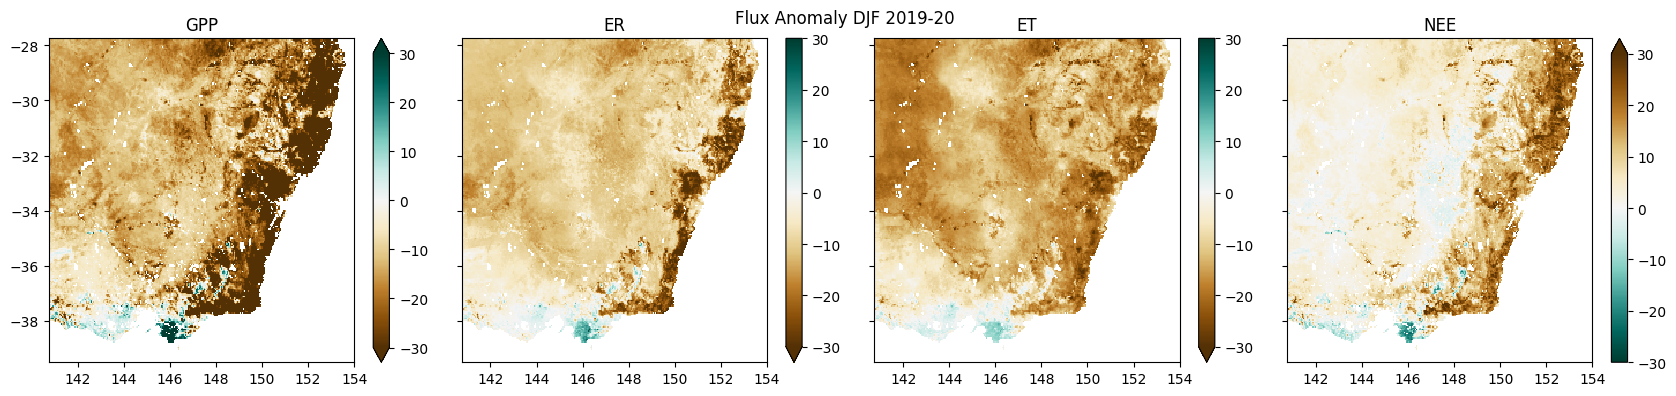

In [21]:
xx = [gpp_anom, er_anom, et_anom, nee_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').rename('').plot.imshow(ax=a, cmap=cmap, vmin=-30, vmax=30)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Anomaly DJF 2019-20');

Text(0.5, 0.98, 'Flux Standardized Anomalies DJF 2019-20')

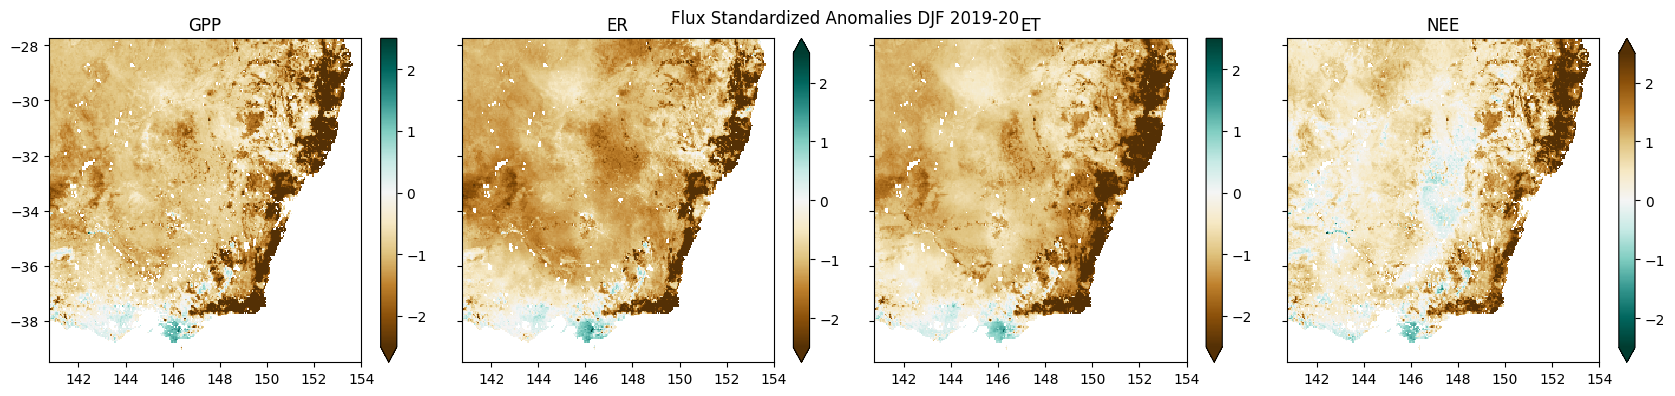

In [22]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').rename('').plot.imshow(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)
plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2019-20');

## Plot extent on interactive map

In [ ]:
# m = folium.Map(control_scale = True)

# # gpp_trend.where(gpp_trend.p_value<0.1).slope.odc.add_to(m, robust=True, cmap='RdBu')
# assign_crs(nee_std_anom.sel(time=slice('2019-10-01', '2020-01-31')).mean('time'), crs='EPSG:4326').odc.add_to(m, vmin=-2.5, vmax=2.5, cmap='BrBG_r')

# # Zoom map to Australia
# m.fit_bounds(nee_std_anom.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)

## Per bioclimatic region + isaggregate further by vegetation types using National Veg Info System

In [23]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [24]:
import rioxarray as rxr
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/climate-carbon-interactions/data/aus6_0e_mvg.tif').squeeze().drop('band')

In [25]:
woody_vals = [1,2,3,5,6,7,8,9,11,12,13,14]
grass_vals = [119,20,21]
shrubs_vals = [15,16,17,18,22,32]
crops_vals = [25]

In [26]:
woody = ds.isin(woody_vals)
grass = ds.isin(grass_vals)
shrubs = ds.isin(shrubs_vals)
crops = ds.isin(crops_vals)

In [27]:
woody = woody.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Woodlands')
grass = grass.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Grasses')
shrubs = shrubs.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Shrubs')
crops = crops.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Crops')

woody =  round_coords(woody)
grass =  round_coords(grass)
shrubs =  round_coords(shrubs)
crops =  round_coords(crops)

### Break veg types into bioclimatic regions

In [28]:
bioclim_masks = []
for index, row in gdf.iterrows():    
    mask = xr_rasterize(gdf.iloc[[index]], gpp.isel(time=1))
    mask = mask.rename(row['region_name'])
    bioclim_masks.append(round_coords(mask))

In [29]:
woody_temperate = woody.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Woody_temperate')
woody_tropics = woody.where(bioclim_masks[0]).astype(np.int8).rename('Woody_tropics')
woody_med = woody.where(bioclim_masks[4]).astype(np.int8).rename('Woody_mediterranean')
woody_semiarid = woody.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Woody_(semi)arid')

crops_med = crops.where(bioclim_masks[4]).astype(np.int8).rename('Crop_mediterranean')
crops_temp = crops.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Crop_temperate')

grasses_semiarid = grass.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Grasses_(semi)arid')

shrubs_semiarid = shrubs.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Shrubs_(semi)arid')

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python3110/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:186

In [31]:
masks = [woody_temperate,woody_tropics,woody_med,woody_semiarid,crops_med,crops_temp, grasses_semiarid, shrubs_semiarid]

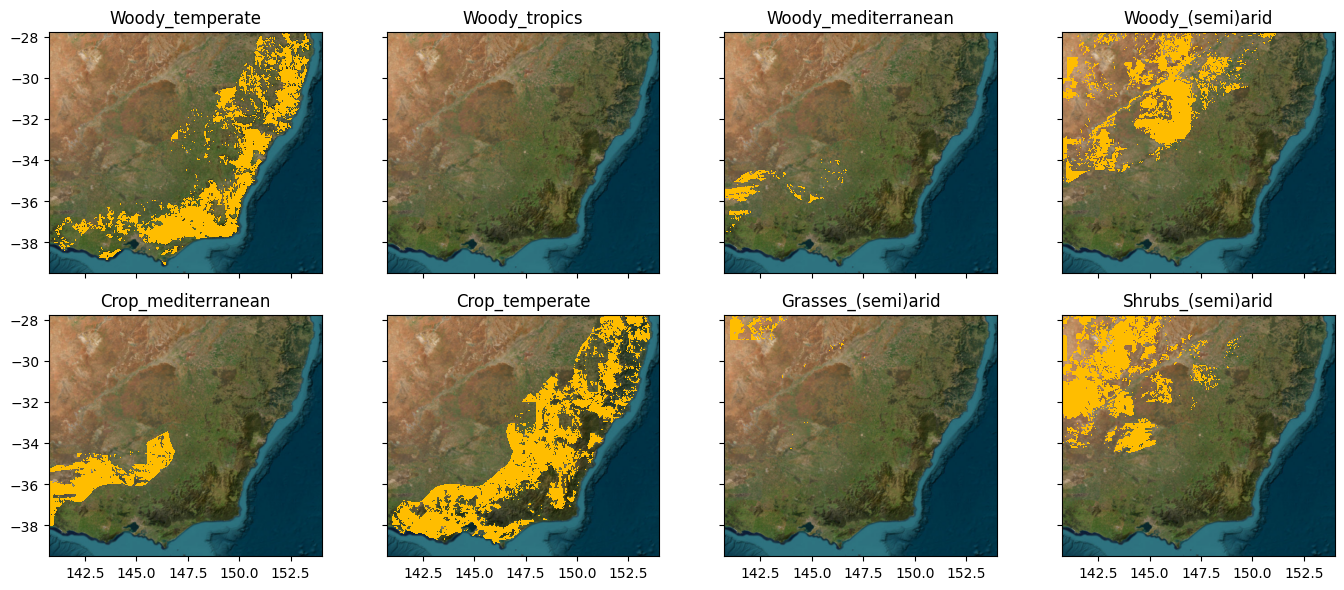

In [32]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharex=True, sharey=True)
for a,m,n in zip(ax.reshape(-1), masks, [mask.name for mask in masks]): 
    m.where(m==1).plot(ax=a, add_colorbar=False, add_labels=False, cmap='Wistia')
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_title(n)
plt.tight_layout();

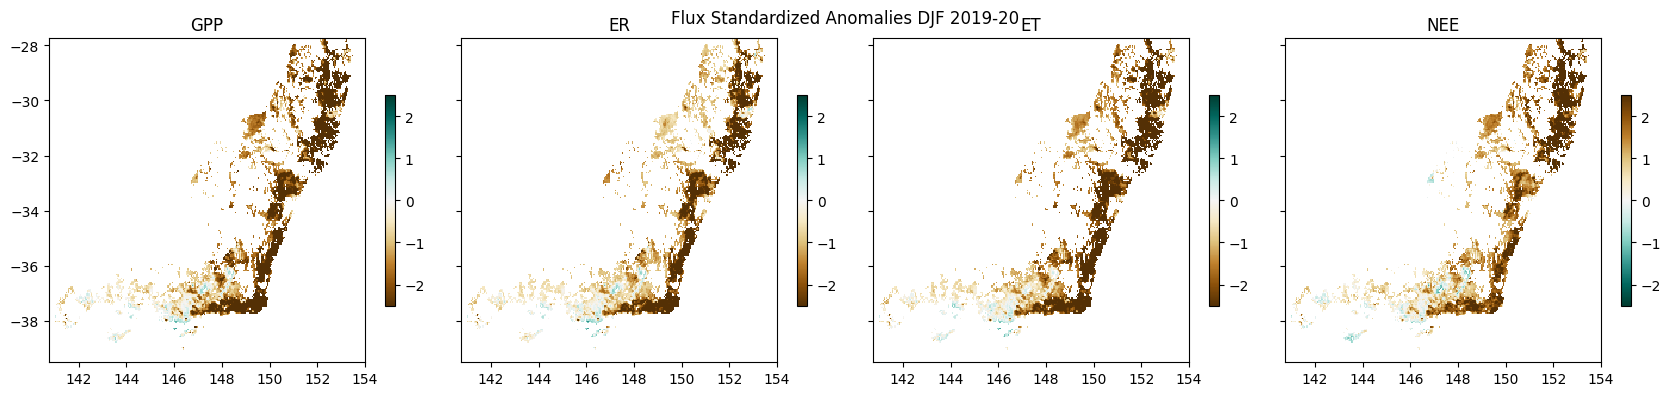

In [33]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.sel(time=slice('2019-12-01', '2020-02-28')).mean('time').where(woody_temperate).rename('').plot.imshow(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    # ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2019-20');

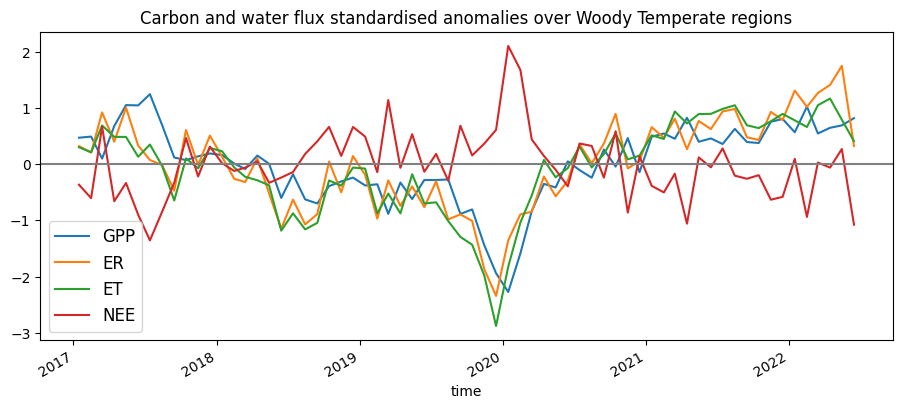

In [34]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp_std_anom.where(woody_temperate).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='GPP')
er_std_anom.where(woody_temperate).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='ER')
et_std_anom.where(woody_temperate).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='ET')
nee_std_anom.where(woody_temperate).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='NEE')

ax.legend(loc='best', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Carbon and water flux standardised anomalies over Woody Temperate regions');

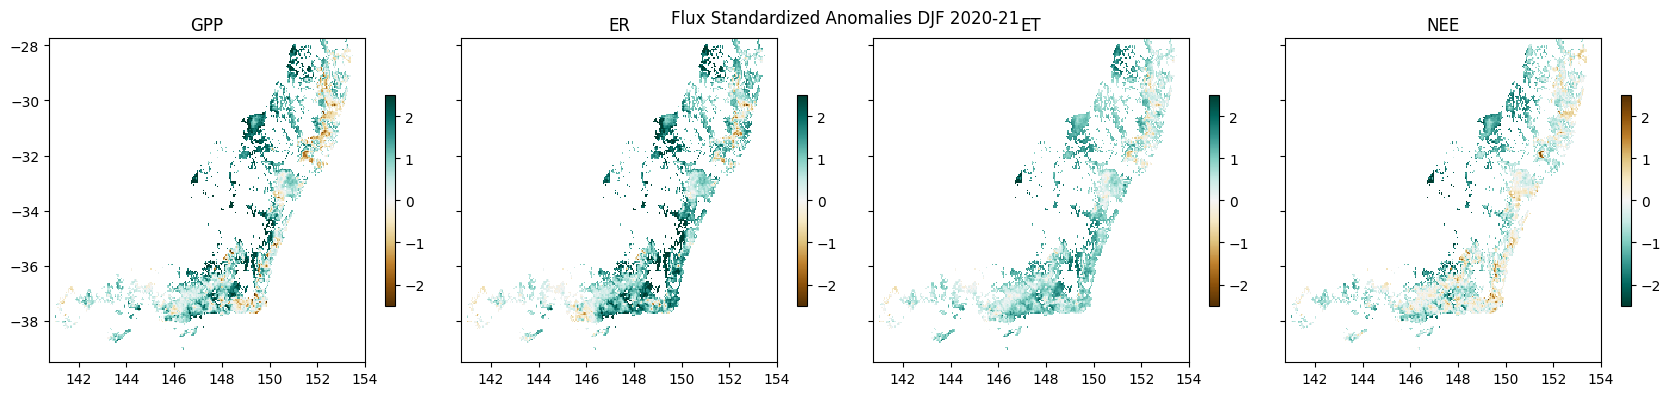

In [36]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.sel(time=slice('2021-12-01', '2022-02-28')).mean('time').where(woody_temperate).rename('').plot.imshow(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    # ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2021-22');

## Plot burned areas only

Text(0.5, 1.0, 'Burned Area Black Summer (MODIS)')

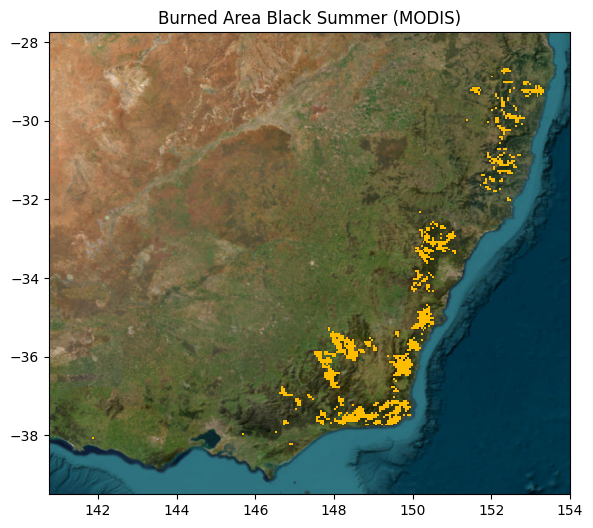

In [87]:
fig,ax = plt.subplots(1,1, figsize=(14,6), sharex=True, sharey=True)
burn.where(burn==True).plot(ax=ax, add_colorbar=False, add_labels=False, cmap='Wistia')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
ax.set_title('Burned Area Black Summer (MODIS)')

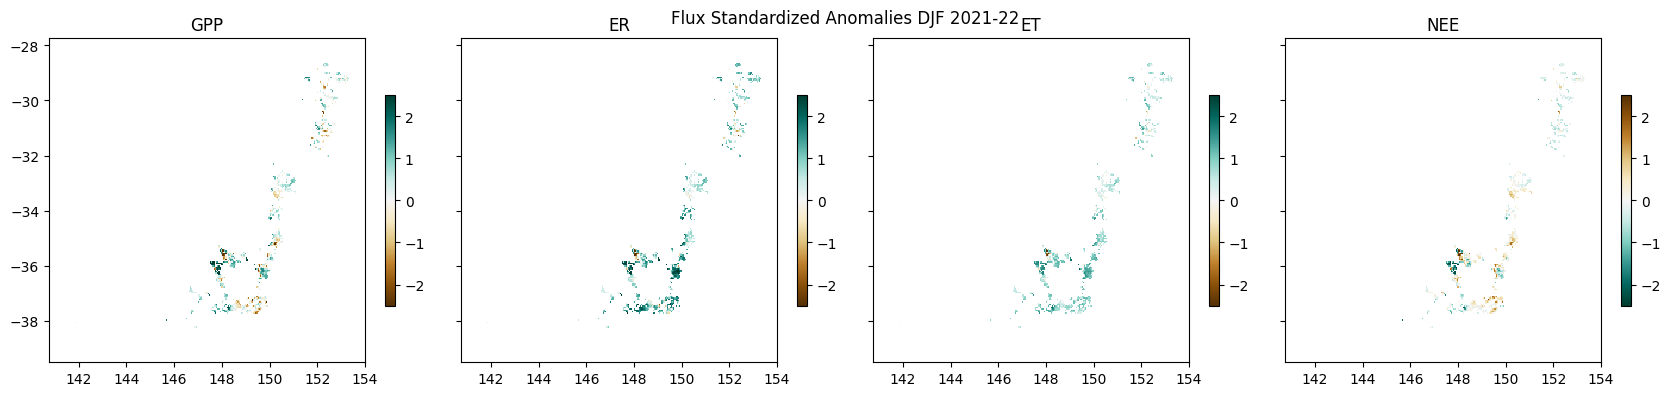

In [90]:
xx = [gpp_std_anom, er_std_anom, et_std_anom, nee_std_anom]
names = ['GPP', 'ER', 'ET', 'NEE']

fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
for a, x, n, i in zip(ax.reshape(-1), xx, names, range(0,len(xx))): 
    if i==3:
        cmap='BrBG_r'
    else:
        cmap='BrBG'
    im = x.sel(time=slice('2021-12-01', '2022-02-28')).mean('time').where(burn).rename('').plot.imshow(ax=a, cmap=cmap, vmin=-2.5, vmax=2.5, add_colorbar=False)
    cbar = plt.colorbar(im, ax=a, shrink=0.65)
    # ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_ylabel(None)
    a.set_xlabel(None)
    a.set_title(n)

plt.tight_layout()
plt.suptitle('Flux Standardized Anomalies DJF 2021-22');

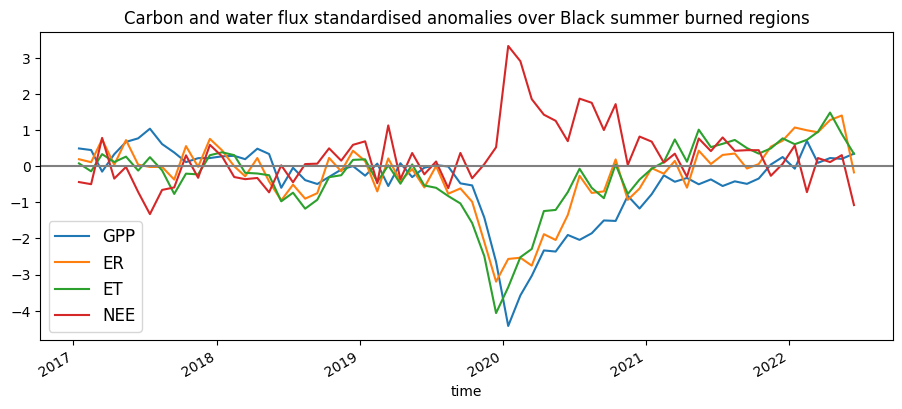

In [91]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp_std_anom.where(burn).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='GPP')
er_std_anom.where(burn).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='ER')
et_std_anom.where(burn).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='ET')
nee_std_anom.where(burn).sel(time=slice('2017', '2022')).mean(['latitude','longitude']).plot(ax=ax, label='NEE')

ax.legend(loc='best', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Carbon and water flux standardised anomalies over Black summer burned regions');